In [1]:
__author__ = 'Robert Nikutta <nikutta@noao.edu>, Stéphanie Juneau <juneau@noao.edu>, Knut Olsen <kolsen@noao.edu>, David Nidever <dnidever@noao.edu>'
__version__ = '20190101' # yyymmdd; version stamp of this notebook
__datasets__ = ['smash_dr1'] # datasets used in this notebook
__keywords__ = ['science example','dwarf galaxies'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] 

# Detecting the Hydra II dwarf galaxy in SMASH DR1

*Robert Nikutta, Stéphanie Juneau, Knut Olsen, David Nidever & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Query the SMASH catalog for blue stars (expected in metal-poor dwarfs)](#query)
* [Spatial density plot](#spatial)
* [Detect overdensities (differential Gaussian kernels)](#kernel)
* [Find peaks](#peaks)
* [Visually inspect images (Simple Image Access)](#sia)
* [CM diagrams of all stars around the peaks](#cmdiagrams)
* [Save your results to a local file](#savefile)
* [Resources](#resource)


<a class="anchor" id="goals"></a>
# Goals

We will use a dwarf galaxy detection algorithm using a spatial overdensity of blue stars to re-discover the Hydra II dwarf galaxy in the SMASH DR1 dataset.


# Summary

**Background**
Ultrafaint dwarf galaxies are crucial to understanding many aspects of the universe. For instance, they are dominated by dark matter; their localization in space can thus trace the large-scale structure of the dark matter distribution. Furthermore, dwarf galaxies are suspected to host intermediate-mass black holes (IMBH), which so far have eluded efforts to find them. IMBHs will naturally bridge the gap between the solar-mass black hole and super-massive blackholes that reside at the center of virtually every large galaxy.

**Data retrieval**
We will retrieve data from Field 169 of the SMASH catalog ([Nidever et al. (2017, AJ, 154, 199)](http://adsabs.harvard.edu/abs/2017AJ....154..199N)) and look for overdensities of blue objects.

The required columns are RA, Dec, and the g, r, i magnitudes.

**Detection**
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done in e.g. [Stanford et al. (2005, ApJ, 634, 2, L129)](http://adsabs.harvard.edu/abs/2005ApJ...634L.129S) (galaxy clusters), or [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K) (MW satellites). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

# Imports and setup

In [2]:
# std lib
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy depracation warnings

# 3rd party
import numpy as np
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb
from photutils import find_peaks
from pyvo.dal import sia
import pylab as plt
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

# plots default setup
plt.rcParams['font.size'] = 14

# Authentication
First, obtain a Data Lab authentication token, which needs to passed along to all Data Lab server-side operations.

In [3]:
token = ac.login(raw_input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  # here we can use the 'anonymous' user name, and an empty password

Enter user name (+ENTER): dnidever
Enter password (+ENTER): ········


 <a class="anchor" id="query"></a>
# Query the SMASH DR1 database

We will query the averaged photometry table from the SMASH catalog and select field #169.  We will limit the query to avoid photometry taken only with short exposures (depthflag>1), avoid broad objects (|sharp|<0.5), and pick blue objects (-0.4 < g-r < 0.4). We will also exclude objects with less than 4 detections to improve the spatial SNR.

## Construct the query string

In [4]:
field = 169 # SMASH field number to query

# Create the query string; SQL keyword capitalized for clarity
#   depth > 1 = no short exposures please
#   ndetr, ndetg > 3 = more than 3 detections in r & g bands
#   abs(sharp) < 0.5 = avoid broad objects
query =\
"""SELECT ra,dec,gmag,rmag,imag
   FROM smash_dr1.object
   WHERE fieldid = '{:d}' AND
         depthflag > 1 AND
         ndetr > 3 AND ndetg > 3 AND
         abs(sharp) < 0.5 AND
         gmag BETWEEN 9 AND 25 AND
         (gmag-rmag) BETWEEN -0.4 AND 0.4""".format(field)

# Submit the query
Running the query in synchroneous mode is very easy.

In [5]:
%%time
response = qc.query(query) # response is by default a CSV-formatted string

CPU times: user 189 ms, sys: 90.4 ms, total: 279 ms
Wall time: 17.4 s


We can use a helper function to convert the query result into a data structure. Let's convert to a Pandas dataframe:

In [6]:
R = convert(response,'pandas') # R is a pandas dataframe
print("Number of objects:", R.shape[0])
print(R.head())

('Number of objects:', 104974)
           ra        dec     gmag     rmag     imag
0  184.521035 -30.601513  23.5397  23.4913  23.3107
1  184.528382 -30.557100  24.0696  23.8885  23.8871
2  184.529856 -30.575441  24.5478  24.2752  23.9898
3  184.540428 -30.581778  23.8669  23.6124  23.1501
4  184.541131 -30.590160  23.5681  23.2770  22.8786


<a class="anchor" id="spatial"></a>
# Make a figure of the spatial distribution

You might spot some overdensities already.

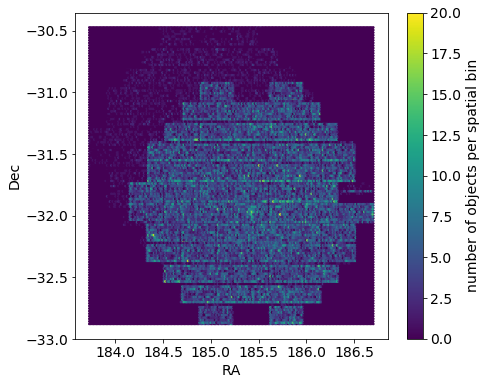

In [7]:
fig = plt.figure(figsize=(7,6))
plt.hexbin(R['ra'], R['dec'],gridsize=200)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='number of objects per spatial bin');

<a class="anchor" id="kernel"></a>
# The Dwarf Filter
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [8]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution .... ",)

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    print('dwarf_filter: mean = {:g}  sigma = {:g} sigmaRaw = {:g}'.format(mean, sigma, sigmaRaw))

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

# Run the dwarf filter
We'll use the default convolution kernels of 2 and 20 arcminutes in size.

In [9]:
%%time
small_k, big_k = 2., 20.  # kernel sizes in arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(R['ra'],R['dec'],fwhm_small=small_k,fwhm_big=big_k)

('Computing differential convolution .... ',)
dwarf_filter: mean = 0.0890555  sigma = 1.79455 sigmaRaw = 5.33591
CPU times: user 246 ms, sys: 7.66 ms, total: 254 ms
Wall time: 258 ms


# Plot the convolved 2D histogram

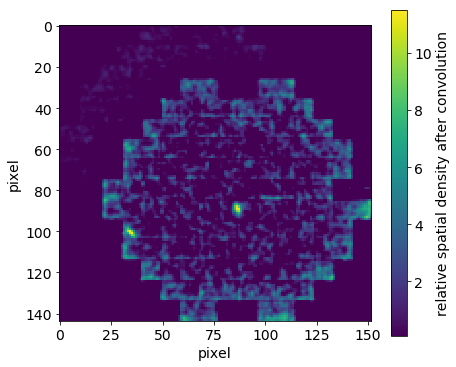

In [10]:
fig, ax = plt.subplots(figsize=(7,6))
im = plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

**Some peaks are visible, let's locate them automatically...**

<a class="anchor" id="peaks"></a>
# Identify peaks
We'll use the `photutils` package to identify 10-sigma peaks in the clipped filtered image.

In [11]:
# find peaks
mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
tbl = find_peaks(clipped,median+10,box_size=small_k*2)

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print(tbl)

x_peak y_peak     peak_value             ra                 dec        
------ ------ ------------------ ------------------ -------------------
    86     89 11.311524537935025  185.4105595327072 -31.976003447411706
    34    100 11.512626647783852 184.39348041275318  -32.15954180336247


# Show the identified density peaks

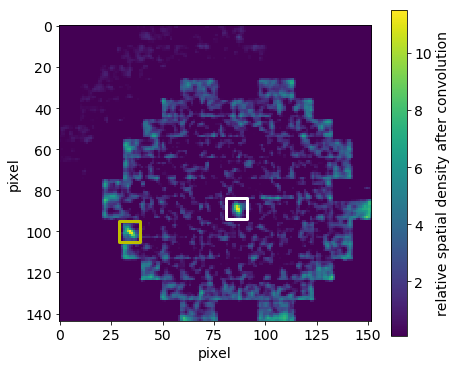

In [12]:
ecs = ['w','y'] # colors of box frames
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

<a class="anchor" id="sia"></a>
# Inspect the image cutouts around the peaks
# *Simple Image Access service*
Data Lab comes with batteries included. Image cutout and download services are built in.

We'll just write two little functions:

* one to download the deepest stacked images found in the given bands at a given position in the sky
* and a function to plot several images side-by-side.

In [13]:
# set up SIA
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/smash"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    sel0 = (imgTable['proctype'] == b'Stack') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band)) #, end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

# Get images for the "left yellow" box
Download the deepest stacked image cutouts (in 3 bands) around the position of the peak marked with a yellow box. Depending on network speed and system load, this can take a few seconds. Also create a 3-band false-color composite.

In [14]:
bands = list('gri')
idx = 1
print(tbl['ra'][idx], tbl['dec'][idx])
images = download_deepest_images(tbl['ra'][idx], tbl['dec'][idx], fov=0.1, bands=bands) # FOV in deg

(184.39348041275318, -32.15954180336247)
The full image list contains 2649 entries.
Band g: 
downloading deepest stacked image...
Band r: 
downloading deepest stacked image...
Band i: 
downloading deepest stacked image...
Downloaded 3 images.


Plot the images, plus a false-color 3-band image:

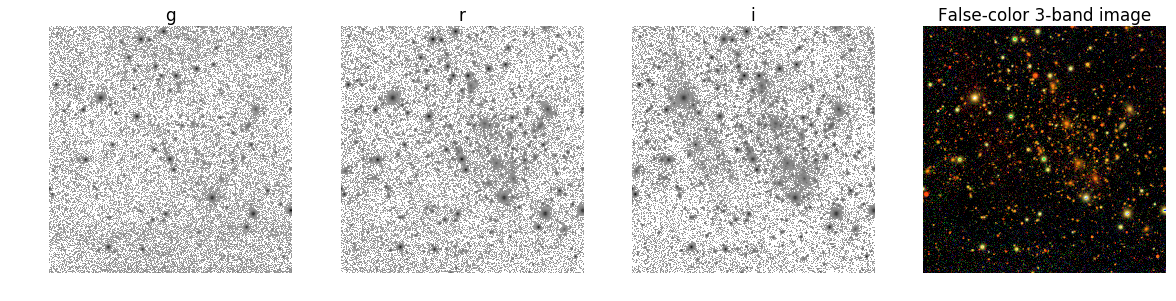

In [15]:
images = [im-np.median(im) for im in images] # subtract median from all images for better scaling
images += [make_lupton_rgb(*images[::-1],stretch=30)] # add a 3-color composite image
plot_images(images,geo=(4,1),titles=bands+['False-color 3-band image'])

**Looks like a galaxy cluster!**

# Now the "white center box" object

The full image list contains 2739 entries.
Band g: 
downloading deepest stacked image...
Band r: 
downloading deepest stacked image...
Band i: 
downloading deepest stacked image...
Downloaded 3 images.


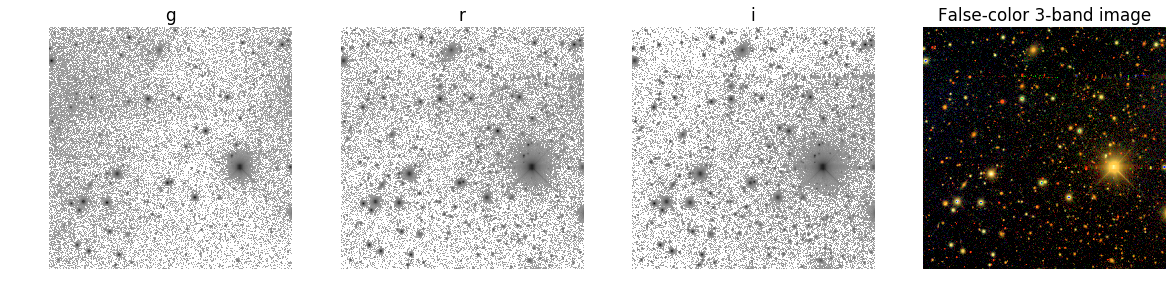

In [16]:
idx = 0
images = download_deepest_images(tbl['ra'][idx], tbl['dec'][idx], fov=0.1, bands=bands) # FOV in deg
images = [im-np.median(im) for im in images] # subtract median from all images for better scaling
images += [make_lupton_rgb(*images[::-1],stretch=30)] # add a 3-color composite image
plot_images(images,titles=bands+['False-color 3-band image'])

**Definitely not a galaxy cluster, but a stellar overdensity**

<a class="anchor" id="cmdiagrams"></a>
# Query the database for stars near peaks
Get photometry of stars within a 5 arcmin radius of each density peak.

In [17]:
def makequery(ra0,dec0,radius0=5./60.,field=169):
    query = """
SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
  WHERE fieldid = {:d}
    AND depthflag > 1
    AND abs(sharp) < 0.5
    AND gmag BETWEEN 9 AND 25
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
""".format(field,ra0,dec0,radius0)

    return query

In [18]:
query0 = makequery(tbl['ra'][0],tbl['dec'][0]) # center ra & dec
response = qc.query(sql=query0) # using sql argument instead of the default adql
R0 = convert(response,'pandas')
print(R0.head()) # a Pandas method

           ra        dec     gmag     rmag     imag
0  185.336254 -31.926618  24.3635  24.1359  24.0324
1  185.346606 -31.918652  23.6957  22.3913  21.8291
2  185.345966 -31.913599  24.7841  24.6622  24.6659
3  185.343793 -31.924141  23.2502  22.2619  21.8387
4  185.339001 -31.929254  18.9246  18.1196  17.8403


# Compute color

In [19]:
R0['g_r'] = R0['gmag'] - R0['rmag']
print( R0.head())

           ra        dec     gmag     rmag     imag     g_r
0  185.336254 -31.926618  24.3635  24.1359  24.0324  0.2276
1  185.346606 -31.918652  23.6957  22.3913  21.8291  1.3044
2  185.345966 -31.913599  24.7841  24.6622  24.6659  0.1219
3  185.343793 -31.924141  23.2502  22.2619  21.8387  0.9883
4  185.339001 -31.929254  18.9246  18.1196  17.8403  0.8050


# Now the other peak

In [20]:
query1 = makequery(tbl['ra'][1],tbl['dec'][1])
R1 = convert(qc.query(sql=query1),'pandas')
R1['g_r'] = R1['gmag'] - R1['rmag'] # compute color
print(R1.tail()) # another Pandas methodb

              ra        dec     gmag     rmag     imag     g_r
2170  184.386677 -32.125573  17.4630  17.0735  16.9112  0.3895
2171  184.343087 -32.230559  21.5835  17.9011  17.6411  3.6824
2172  184.417583 -32.146684  18.7891  17.4206  16.7485  1.3685
2173  184.392450 -32.101194  17.7037  17.3677  17.2325  0.3360
2174  184.395964 -32.202450  24.2713  25.0283  24.8350 -0.7570


# Color-magnitude diagrams of the peaks

In [21]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)

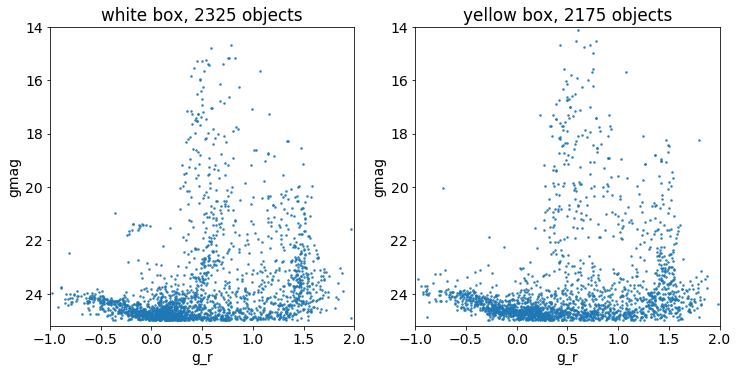

In [22]:
fig = plt.figure(figsize=(12,5.5))
plotpanel(121,R0['g_r'],R0['gmag'],'white box, {:d} objects'.format(len(R0)))
plotpanel(122,R1['g_r'],R1['gmag'],'yellow box, {:d} objects'.format(len(R1)))

# Compare w/ Vivas+2016
￼￼￼<img style="float: left;" src="Vivas2016fig9.png">

# Save your photmetry table
If you wish, you can now save your photometry table for Hydra II to a local file and take it with you.

In [23]:
outfile = 'hydra2.csv'
R0.to_csv(outfile,index=False)

[hydra2.csv](hydra2.csv) <-- Download the file as you please.

# Some ideas for improvement

* Find overdensities elsewhere (everywhere!)

* optimize kernel sizes, computation, proper wavelets

# Some resources


Nidever et al. (2017) "SMASH - Survey of the MAgellanic Stellar History": http://adsabs.harvard.edu/abs/2017AJ....154..199N

Stanford et al. (2005, ApJ, 634, 2, L129) "An IR-selected Galaxy Cluster at z = 1.41": http://adsabs.harvard.edu/abs/2005ApJ...634L.129S

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K

Martin et al. (2015, ApJ, 804, 5) "Hydra II: A Faint and Compact Milky Way Dwarf Galaxy Found in the Survey of the Magellanic Stellar History": http://adsabs.harvard.edu/abs/2015ApJ...804L...5M